# Information

- Full paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4374466/

# Libraries

1) Install Anaconda

    - Run 'brew cask install anaconda'
    - Add 'export PATH=/usr/local/anaconda3/bin:"$PATH"' to '.bash_profile' or to '.bashrc'

2) Install MNE (https://martinos.org/mne/stable/install_mne_python.html)

    - Run 'conda --version && python --version'
    - Run:
        - curl -O https://raw.githubusercontent.com/mne-tools/mne-python/master/environment.yml
        - conda env create -f environment.yml
        - source activate mne

## Load libraries

In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import joblib

from random import randint
from scipy import interp
import sklearn.linear_model as linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

## Config libraries

In [2]:
mne.set_log_level('WARNING')

# Dataset

## Load signals

- https://martinos.org/mne/stable/auto_tutorials/plot_creating_data_structures.html

In [3]:
# source file with eeg channel data and stimulus
vhdr_file = '../data/grid_lights/jose/jose1/record-bv-generic-joses-[2019.05.25-16.55.59].vhdr'

# classifier from different experiment data used for classification testing
classifier_in_path = '../classifiers/classifier_nati_2_fit.joblib'

# out path for classifier generated with current experiment's data
classifier_out_path = '../classifiers/classifier_jose_1_fit.joblib'

# Set missing EEG montage (electrode positions)
# https://martinos.org/mne/stable/generated/mne.io.Raw.html#mne.io.Raw.set_montage
# https://mne-tools.github.io/stable/generated/mne.channels.Montage.html
# Electrodes are named and positioned according to the international 10-20 system (94+3 locations)
# https://en.wikipedia.org/wiki/10–20_system_(EEG)
montage = 'standard_1020'

sig_mne = mne.io.read_raw_brainvision(vhdr_file, montage, preload=True)

sig_mne.pick_types(eeg=True, stim=True)  # only use eeg and stim channels

# Do not set reference
# https://martinos.org/mne/dev/auto_tutorials/plot_eeg_erp.html#setting-eeg-reference
# If an empty list is specified, the data is assumed to already have a proper reference
# and MNE will not attempt any re-referencing of the data
sig_mne, _ = mne.set_eeg_reference(sig_mne, [])
sample_rate = sig_mne.info['sfreq']

print('Loaded subject from: {}'.format(vhdr_file))
print('Sample rate: {}'.format(sample_rate))
print(sig_mne)

Loaded subject from: ../data/grid_lights/jose/jose1/record-bv-generic-joses-[2019.05.25-16.55.59].vhdr
Sample rate: 250.0
<RawBrainVision  |  record-bv-generic-joses-[2019.05.25-16.55.59].eeg, n_channels x n_times : 9 x 131328 (525.3 sec), ~9.0 MB, data loaded>


## Sensors

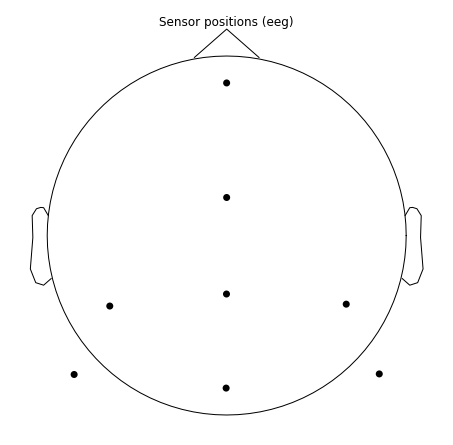

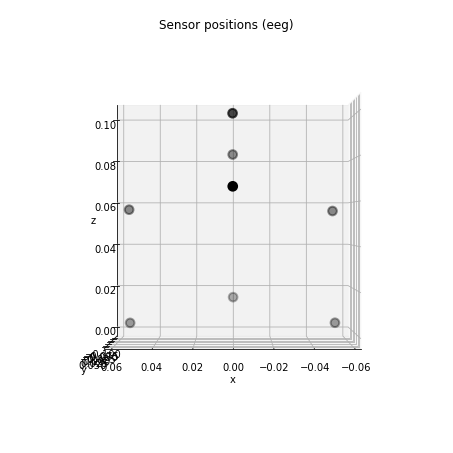

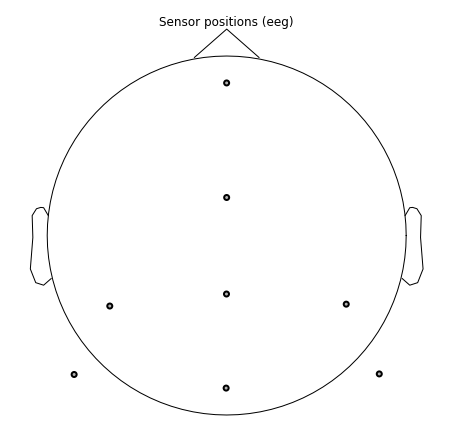

(<Figure size 432x432 with 1 Axes>, [])

In [4]:
# Plot sensors
sig_mne.plot_sensors()
sig_mne.plot_sensors('3d')  # in 3D
sig_mne.plot_sensors('select')

## Plot signals

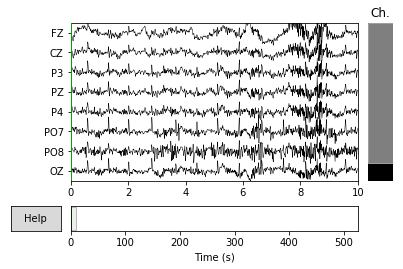

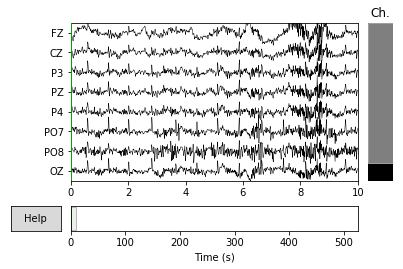

In [5]:
# Plot raw data of first 8 channels
sig_mne.plot(n_channels=8, scalings='auto', block=True)

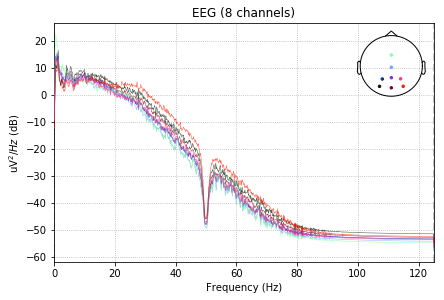

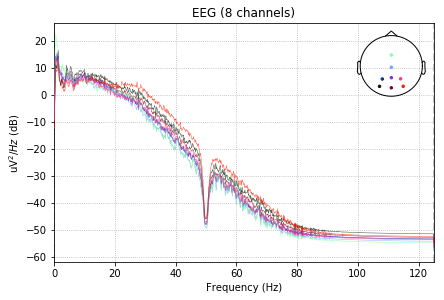

In [6]:
# Compute the power spectral density of raw data
# https://martinos.org/mne/stable/auto_examples/time_frequency/plot_compute_raw_data_spectrum.html
sig_mne.plot_psd()

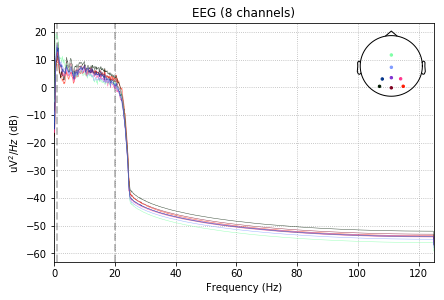

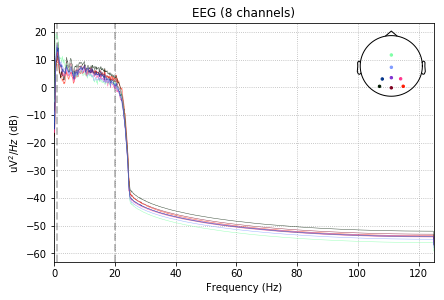

In [7]:
# Band-pass filter data
sig_mne.filter(l_freq=1.0, h_freq=20.0)

# Plot the power spectral density across filtered channels
sig_mne.plot_psd()

In [8]:
# start, stop = raw.time_as_index([100, 115])  # 100 s to 115 s data segment
# data, times = raw[:, start:stop]
# print(data.shape)
# print(times.shape)
# data, times = raw[2:20:3, start:stop]  # access underlying data
# raw.plot()

# Analisys

## Load events

- https://martinos.org/mne/stable/auto_tutorials/plot_creating_data_structures.html
- https://martinos.org/mne/stable/auto_examples/io/plot_read_events.html#ex-read-events

In [9]:
stim_channel_name = 'STI 014'
# Find events
# https://martinos.org/mne/stable/generated/mne.find_events.html
events = mne.find_events(sig_mne, stim_channel=stim_channel_name, output='onset', consecutive=True,
                         min_duration=0, shortest_event=1, mask=None, uint_cast=False, mask_type='and',
                         initial_event=True, verbose=None)
print('Number of events:', len(events))
print('Event codes:', np.unique(events[:, 2]))  # Show all unique event codes (3rd column)
print(events)

Number of events: 229
Event codes: [1 2 3 4]
[[ 11892      0      3]
 [ 12396      0      1]
 [ 12896      0      1]
 [ 13395      0      2]
 [ 13896      0      1]
 [ 14396      0      1]
 [ 14896      0      2]
 [ 15393      0      1]
 [ 15893      0      1]
 [ 16394      0      1]
 [ 16894      0      2]
 [ 17394      0      1]
 [ 17895      0      1]
 [ 18395      0      2]
 [ 18896      0      1]
 [ 19396      0      2]
 [ 19896      0      2]
 [ 20393      0      1]
 [ 20893      0      2]
 [ 21394      0      1]
 [ 21894      0      2]
 [ 22394      0      2]
 [ 22895      0      1]
 [ 23395      0      1]
 [ 23896      0      1]
 [ 24396      0      2]
 [ 24896      0      1]
 [ 25393      0      2]
 [ 25897      0      1]
 [ 26393      0      2]
 [ 26894      0      2]
 [ 27394      0      2]
 [ 27894      0      2]
 [ 28395      0      1]
 [ 28896      0      2]
 [ 29396      0      1]
 [ 29896      0      1]
 [ 30396      0      2]
 [ 30897      0      1]
 [ 31394      0    

In [10]:
finish_experiment_indexes = np.argwhere(events[:, 2]==4).flatten()
print(finish_experiment_indexes)

[ 50 123 228]


In [11]:
events_ids = {'Closer': 1, 'Further': 2}

## Plot events

- https://martinos.org/mne/stable/auto_tutorials/plot_visualize_epochs.html

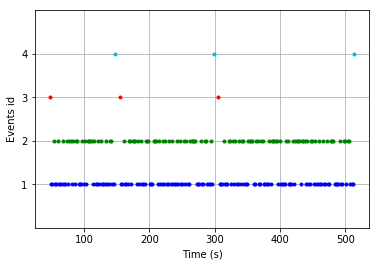

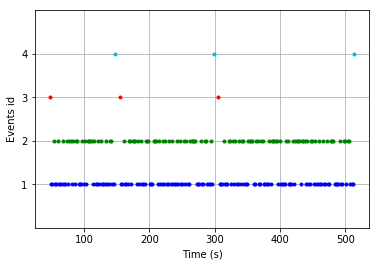

In [12]:
# Plot all events
mne.viz.plot_events(events, sfreq=sample_rate)  # https://martinos.org/mne/stable/generated/mne.viz.plot_events.html

event 3 missing from event_id will be ignored
event 4 missing from event_id will be ignored


<ipython-input-13-a6925a92e072>:2: RuntimeWarning: event 3 missing from event_id will be ignored
  mne.viz.plot_events(events, event_id=events_ids, sfreq=sample_rate)
<ipython-input-13-a6925a92e072>:2: RuntimeWarning: event 4 missing from event_id will be ignored
  mne.viz.plot_events(events, event_id=events_ids, sfreq=sample_rate)


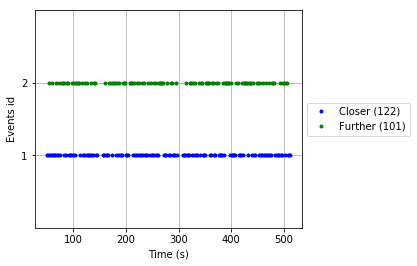

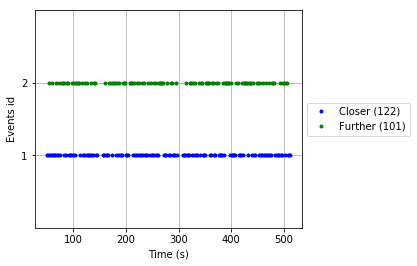

In [13]:
# Plot Closer and Further events
mne.viz.plot_events(events, event_id=events_ids, sfreq=sample_rate)

## Load epochs

In [14]:
events_tmin = -0.2
events_tmax = 2.0
# Find epochs
# https://martinos.org/mne/stable/auto_tutorials/plot_object_epochs.html
epochs = mne.Epochs(sig_mne, events, events_ids, tmin=events_tmin, tmax=events_tmax, baseline=(None, 0),
                    picks=None, preload=True, reject=None, flat=None, proj=False, decim=1,
                    reject_tmin=None, reject_tmax=None, detrend=None, on_missing='error',
                    reject_by_annotation=True, metadata=None, verbose=None)
epochs_labels = epochs.events[:, -1]
print("Labels: ")
print(epochs_labels)
print(epochs)
print('Loaded (#Epochs, #Channels, #Times) = {}'.format(epochs.get_data().shape))

Labels: 
[1 1 2 1 1 2 1 1 1 2 1 1 2 1 2 2 1 2 1 2 2 1 1 1 2 1 2 1 2 2 2 2 1 2 1 1 2
 1 2 1 1 1 2 1 1 2 2 1 1 1 1 2 1 1 1 2 2 1 2 2 2 1 2 1 2 1 1 1 2 2 2 1 1 1
 2 2 2 1 2 1 1 2 1 2 1 1 2 1 2 1 1 1 2 1 2 1 1 2 1 2 1 1 2 2 2 2 2 1 1 1 2
 1 1 2 2 1 1 1 2 1 1 1 1 2 1 1 1 2 2 1 2 1 2 1 1 2 1 2 2 1 1 1 2 2 2 2 1 1
 2 2 1 1 2 2 1 1 1 1 2 1 2 2 2 2 2 1 2 1 1 1 1 2 2 1 1 1 2 1 2 2 2 2 1 2 2
 2 1 2 1 1 2 2 1 2 1 1 2 1 1 2 1 1 2 1 1 2 2 2 1 1 1 1 2 1 1 2 2 1 2 2 1 1
 1]
<Epochs  |   223 events (all good), -0.2 - 2 sec, baseline [None, 0], ~8.5 MB, data loaded,
 'Closer': 122
 'Further': 101>
Loaded (#Epochs, #Channels, #Times) = (223, 9, 551)


## Plot epochs

https://martinos.org/mne/stable/auto_tutorials/plot_visualize_epochs.html

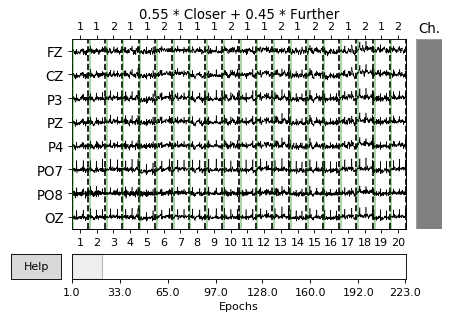

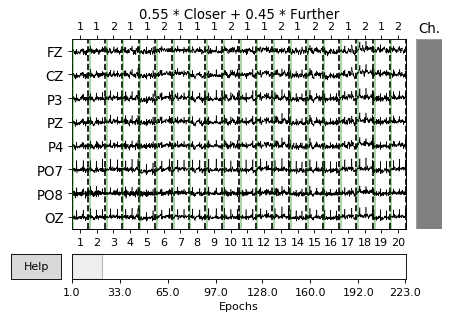

In [15]:
epochs.plot(scalings='auto', block=True)

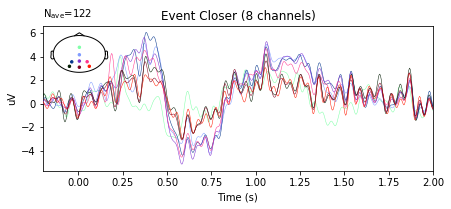

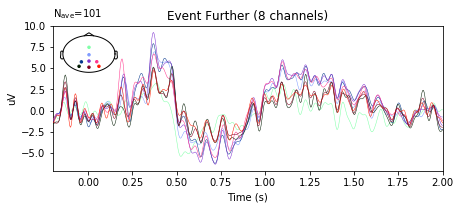

In [16]:
# Plot average for each event type
for each in events_ids:
    epochs[each].average().plot(titles=('Event ' + each), time_unit='s', spatial_colors=True)

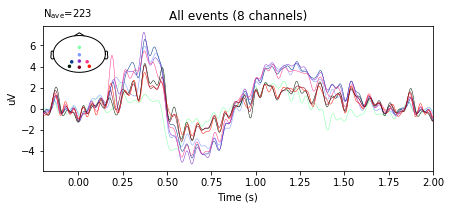

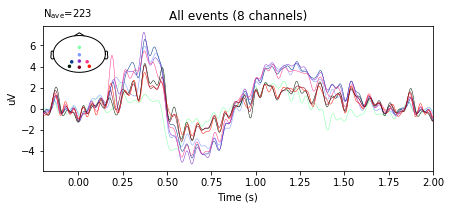

In [17]:
# Plot average for all types
epochs.average().plot(titles='All events', time_unit='s', spatial_colors=True)

## Train

- http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
- http://scikit-learn.org/stable/tutorial/basic/tutorial.html

In [18]:
target_names = ['noerror', 'error']
error_label = 2
hits_epochs_labels = np.array([1 if x == error_label else 0 for x in epochs_labels])
# random labels
# hits_epochs_labels = np.asarray([randint(0,1) for i in range(len(hits_epochs_labels))])
print(epochs_labels)
print(hits_epochs_labels)


# print(epochs['Closer'][0].event_id)

[1 1 2 1 1 2 1 1 1 2 1 1 2 1 2 2 1 2 1 2 2 1 1 1 2 1 2 1 2 2 2 2 1 2 1 1 2
 1 2 1 1 1 2 1 1 2 2 1 1 1 1 2 1 1 1 2 2 1 2 2 2 1 2 1 2 1 1 1 2 2 2 1 1 1
 2 2 2 1 2 1 1 2 1 2 1 1 2 1 2 1 1 1 2 1 2 1 1 2 1 2 1 1 2 2 2 2 2 1 1 1 2
 1 1 2 2 1 1 1 2 1 1 1 1 2 1 1 1 2 2 1 2 1 2 1 1 2 1 2 2 1 1 1 2 2 2 2 1 1
 2 2 1 1 2 2 1 1 1 1 2 1 2 2 2 2 2 1 2 1 1 1 1 2 2 1 1 1 2 1 2 2 2 2 1 2 2
 2 1 2 1 1 2 2 1 2 1 1 2 1 1 2 1 1 2 1 1 2 2 2 1 1 1 1 2 1 1 2 2 1 2 2 1 1
 1]
[0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1
 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0
 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1
 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0
 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1
 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0
 0]


In [19]:
def cross_val(classifier, cross_validator, epochs, hits_epochs_labels):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0

    plt.figure(figsize=(20, 10))
    # Do cross-validation
    for train_index, test_index in cross_validator.split(epochs, hits_epochs_labels):
#         print(train_index)
#         print(test_index)
        data_train, data_test = epochs[train_index], epochs[test_index]
        labels_train, labels_test = hits_epochs_labels[train_index], hits_epochs_labels[test_index]
        classifier_fit = classifier.fit(data_train, labels_train)
        
        prediction = classifier_fit.predict(data_test)
        prediction_proba = classifier_fit.predict_proba(data_test)
        print("Accuracy of iteration {}: {}".format(i, accuracy_score(labels_test, prediction)))
        # ROC curve for fold i
        # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
        fpr, tpr, thresholds = roc_curve(labels_test, prediction_proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        

    # Chance line
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    # Mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    # Std. dev. ROC
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    # Plot ROC
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.xlim([-0.05, 1.05])
    plt.ylabel('True positive radte')
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="best")
    plt.show()

In [20]:
def print_confusion_matrix(classifier, data_test, labels_test, cross_validator=None):
    if cross_validator is None:
        predictions = classifier.predict(data_test)
    else:
        predictions = cross_val_predict(classifier, data_test, hits_epochs_labels, cv=cross_validator)
    confusion_m = confusion_matrix(hits_epochs_labels, predictions)
    print("Confusion matrix")
    print(confusion_m)

    # Normalized confusion matrix
    confusion_m_norm = confusion_m.astype(float) / confusion_m.sum(axis=1)[:, np.newaxis]

    # Plot it
    plt.imshow(confusion_m_norm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(target_names))
    plt.title('Normalized Confusion matrix')
    plt.xlabel('Predicted label')
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.ylabel('True label')
    plt.yticks(tick_marks, target_names)
    plt.clim(0,1)
    plt.colorbar()
    mne.viz.tight_layout()
    plt.show()

In [21]:
new_epochs = epochs.get_data()[:,:7,:]

In [22]:
from sklearn.pipeline     import Pipeline
from sklearn.svm          import LinearSVC, SVC
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression

multi_classification_pipeline = Pipeline([
    ('vectorizer', mne.decoding.Vectorizer()),
    ('normalizer', MinMaxScaler()),
    ('classifier', LogisticRegression(penalty='l1'))
])
multi_cross_validator = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

classifiers = [
    LinearSVC(), # http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
    KNeighborsClassifier(n_neighbors=5), # http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    SVC(), # http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    SGDClassifier(), # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
    LogisticRegression(), # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
]

for classifier in classifiers:
    print('Classifier', str(classifier))
    multi_classification_pipeline.set_params(classifier=classifier)
    multi_predictions = np.empty(len(hits_epochs_labels))
    for train_index, test_index in multi_cross_validator.split(new_epochs, hits_epochs_labels):
        print("TRAIN SIZE:", len(train_index), 'TEST SIZE:', len(test_index))
        data_train, data_test             = new_epochs[train_index], new_epochs[test_index]
        labels_train                      = hits_epochs_labels[train_index]
        multi_classification_pipeline_fit = multi_classification_pipeline.fit(data_train, labels_train)
        multi_predictions[test_index]     = multi_classification_pipeline.predict(data_test)
    multi_report = classification_report(hits_epochs_labels, multi_predictions, target_names=target_names)
    print(multi_report)

Classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
TRAIN SIZE: 199 TEST SIZE: 24
TRAIN SIZE: 200 TEST SIZE: 23
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
             precision    recall  f1-score   support

    noerror       0.63      0.63      0.63       122
      error       0.55      0.55      0.55       101

avg / total       0.60      0.60      0.60       223

Classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
TRAIN SIZE: 199 TEST SIZE: 24
TRAIN SIZE: 200 TEST SIZE: 23
TRAIN SIZE: 201 TEST SIZ

/usr/local/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in

             precision    recall  f1-score   support

    noerror       0.55      1.00      0.71       122
      error       0.00      0.00      0.00       101

avg / total       0.30      0.55      0.39       223

Classifier SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
TRAIN SIZE: 199 TEST SIZE: 24
TRAIN SIZE: 200 TEST SIZE: 23
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
TRAIN SIZE: 201 TEST SIZE: 22
             precision    recall  f1-score   support

    noerror       0.60      0.73      0.66       122
      error       0.55      0.41      0.47 

Accuracy of iteration 0: 0.625
Accuracy of iteration 1: 0.6521739130434783
Accuracy of iteration 2: 0.6818181818181818
Accuracy of iteration 3: 0.6363636363636364
Accuracy of iteration 4: 0.45454545454545453
Accuracy of iteration 5: 0.6818181818181818
Accuracy of iteration 6: 0.5
Accuracy of iteration 7: 0.6818181818181818
Accuracy of iteration 8: 0.6363636363636364
Accuracy of iteration 9: 0.45454545454545453


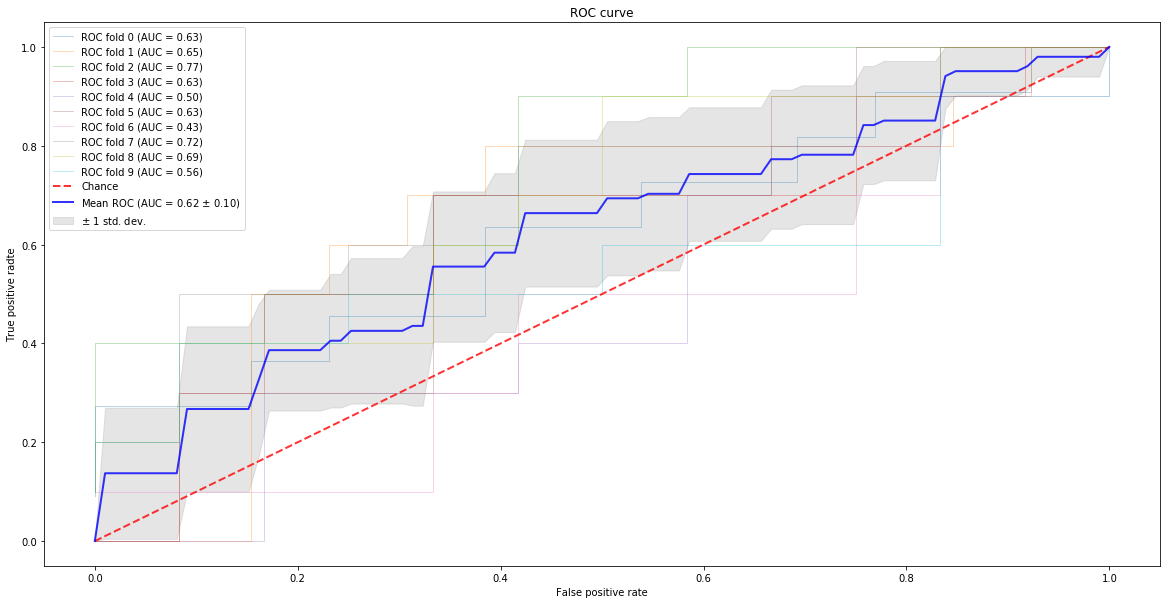

Confusion matrix
[[78 44]
 [45 56]]


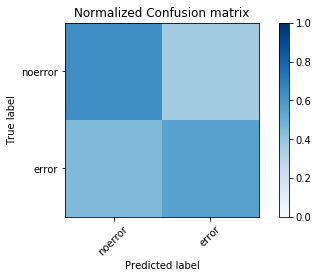

In [23]:
# print(epochs.events[:, -1])
# mne.epochs.combine_event_ids(epochs, ['Closer','Further'], 0, copy=False)
# print(epochs.events[:, -1])
# new_epochs = epochs.get_data()[:,:7,:]

# Set classification pipeline
classifier = make_pipeline(
    mne.decoding.Vectorizer(),  # Transform n-dimensional array into 2D array of n_samples by n_features.
    MinMaxScaler(),  # Transforms features by scaling each feature to a given range (0, 1).
    LogisticRegression()  # linear model for classification
#     SGDClassifier(loss='modified_huber')
#     linear_model.BayesianRidge()
#     KNeighborsClassifier(n_neighbors=8)
    
)
# Set cross-validator
# Stratified K-Folds cross-validator
# Provides train/test indices to split data in train/test sets
# This cross-validation object is a variation of KFold that returns stratified folds
# Stratification is done based on the labels provided in split(_, labels)
# The folds are made by preserving the percentage of samples for each class
# https://machinelearningmastery.com/k-fold-cross-validation/
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

cross_validator = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cross_val(classifier, cross_validator, new_epochs, hits_epochs_labels)
print_confusion_matrix(classifier, new_epochs, hits_epochs_labels, cross_validator=cross_validator)

In [24]:
def train_classifier():
    # Set classification pipeline
    # TODO: Test classificators
    classifier = make_pipeline(
        mne.decoding.Vectorizer(),  # Transform n-dimensional array into 2D array of n_samples by n_features.
        MinMaxScaler(),  # Transforms features by scaling each feature to a given range (0, 1).
        LogisticRegression()  # linear model for classification
    )

    data_train = new_epochs
    labels_train = hits_epochs_labels

    classifier_fit = classifier.fit(data_train, labels_train)
    joblib.dump(classifier_fit, classifier_out_path)

In [25]:
train_classifier()

## Test

In [26]:
def predict(classifier, data_test, labels_test):
    
    fprs = np.linspace(0, 1, 100)
    
    prediction = classifier.predict(data_test)
    prediction_proba = classifier.predict_proba(data_test)
    print("Accuracy: {}".format(accuracy_score(labels_test, prediction)))
    # ROC curve for fold i
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    fpr, tpr, thresholds = roc_curve(labels_test, prediction_proba[:, 1])
    tprs = interp(fprs, fpr, tpr)
    tprs[0] = 0.0
    tprs[-1] = 1.0
    roc_auc = auc(fprs, tprs)
    std_auc = np.std(roc_auc)
    
    plt.figure(figsize=(20, 10))
    plt.plot(fprs, tprs, color='b', label=r'ROC (AUC = %0.2f $\pm$ %0.2f)' % (roc_auc, std_auc),
         lw=2, alpha=.8)
    
    # Chance line
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.xlim([-0.05, 1.05])
    plt.ylabel('True positive radte')
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="best")
    plt.show()

Accuracy: 0.515695067264574


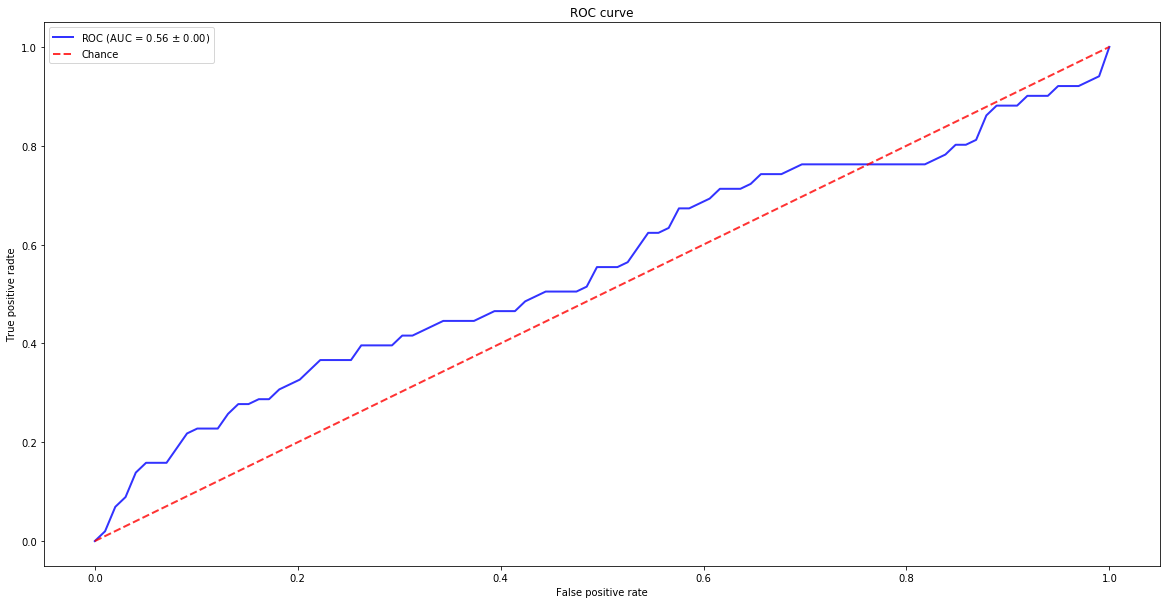

In [27]:
if classifier_in_path is not None:
    classifier = joblib.load(classifier_in_path)
    data_test = new_epochs
    labels_test = hits_epochs_labels
    predict(classifier, data_test, labels_test)

## Confusion matrix

Confusion matrix
[[58 64]
 [44 57]]


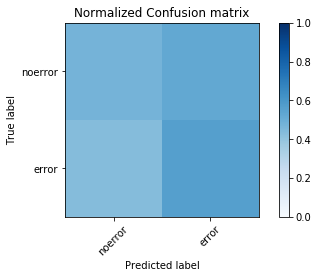

In [28]:
print_confusion_matrix(classifier, data_test, labels_test)

## Prediction to reward

In [29]:
def grid_lights_rewards(prediction):
    if prediction is None:
        return 10
    else:
        return -1 * prediction

In [30]:
def prediction_2_reward(predictions, reward_function):
    return reward_function(predictions)

In [31]:
prediction_2_reward(classifier.predict(data_test), grid_lights_rewards)

array([-1,  0, -1, -1, -1, -1, -1,  0, -1, -1,  0, -1,  0, -1, -1,  0,  0,
        0,  0,  0,  0,  0, -1,  0, -1,  0,  0, -1,  0,  0,  0, -1, -1, -1,
       -1,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0, -1, -1,  0,  0,  0,  0,
        0, -1, -1,  0,  0, -1, -1,  0,  0, -1,  0,  0, -1, -1,  0, -1,  0,
       -1,  0, -1, -1, -1,  0, -1, -1, -1,  0, -1, -1, -1,  0,  0, -1, -1,
       -1,  0,  0, -1, -1, -1, -1,  0, -1, -1,  0, -1, -1,  0, -1, -1,  0,
        0, -1,  0,  0,  0,  0, -1,  0, -1, -1,  0, -1, -1,  0, -1, -1, -1,
        0, -1, -1,  0, -1, -1, -1,  0, -1,  0,  0, -1, -1, -1, -1, -1, -1,
        0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0, -1,  0,  0,  0,
       -1,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0, -1, -1,  0,  0, -1, -1,
       -1,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1,  0,  0, -1,  0,  0, -1, -1,  0, -1,  0,  0,  0, -1,  0,
       -1,  0, -1,  0,  0, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1,  0, -1,
        0, -1])

In [32]:
def state_reward_merge(state_files, rewards, reward_function, output_file):
    rewards = list(rewards)
    with open(output_file, "w") as out:
        experiment_name = None
        file_content = ""
        for state_file in state_files:
            with open(state_file, "r") as inp:
                if experiment_name is None:
                    experiment_name = inp.readline()
                    file_content += experiment_name
                elif experiment_name != inp.readline():
                    raise Exception("Experiments are different.")
                    
                is_first_state = True
                    
                for line in inp:
                    if line != "\n":
                        file_content += line
                    else:
                        if is_first_state:
                            is_first_state = False
                            file_content += str(reward_function(0)) + "\n"
                        else:
                            file_content += str(rewards.pop(0)) + "\n"
                file_content += "\n" + str(reward_function(None)) + "\n--\n"
        
        out.write(file_content)


In [33]:
state_reward_merge(["/Users/franbartolome/Documents/git/pf/experiments/experiences/25:5:19/Juan/grid_lights_experiment_juan_1",
                   "/Users/franbartolome/Documents/git/pf/experiments/experiences/25:5:19/Juan/grid_lights_experiment_juan_2",
                   "/Users/franbartolome/Documents/git/pf/experiments/experiences/25:5:19/Juan/grid_lights_experiment_juan_3"],
                  prediction_2_reward(classifier.predict(data_test), grid_lights_rewards), grid_lights_rewards, "results_juan.txt")

IndexError: pop from empty list

In [ ]:
# https://scikit-learn.org/stable/modules/cross_validation.html
# scoring = None
# scoring = 'roc_auc'
# scores = cross_val_score(classifier, epochs.get_data(), hits_epochs_labels, cv=cross_validator, scoring=scoring)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))